# Set up

In [1]:
# adapted from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

import torch
from torch import nn
from torch import distributions as d
from torch.utils.data import Dataset, DataLoader
import scipy.stats as sps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


# model class for a univariate normal distribution
class normModel(nn.Module):
    def __init__(self, init_loc=None, init_scale=None):
        super().__init__()
        if init_loc is not None:
            self.loc = nn.Parameter(init_loc)
        else: 
            self.loc = nn.Parameter(torch.randn(1))
        
        if init_scale is not None:
            self.scale = nn.Parameter(init_scale)
        else:
            self.scale = nn.Parameter(torch.abs(torch.randn(1)))
        
        self.dist = d.Normal(self.loc, self.scale)


# loss functions

# nll_loss is not actually used below
# def nll_loss(model, x):
#     return -torch.sum(model.dist.log_prob(x))


q_lvls = np.array([[0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,
                    0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]])
norm_offsets = torch.Tensor(sps.norm.ppf(q_lvls))
q_lvls = torch.Tensor(q_lvls)

def quantile_loss(model, x):
    """
    adapted from https://pytorch-forecasting.readthedocs.io/en/stable/_modules/pytorch_forecasting/metrics/quantile.html#QuantileLoss
    """
    losses = []
    pred = model.loc + model.scale * norm_offsets
    errors = torch.unsqueeze(x, -1) - pred
    losses = 2 * torch.max((q_lvls - 1) * errors, q_lvls * errors)
    return torch.sum(losses)


# train model on given data x_train, optimizing loss_fn
def train_once(loss_fn, x_train, epochs, learning_rate):
    model = normModel(
        init_loc = torch.mean(x_train),
        init_scale = torch.std(x_train, dim=None, correction=0)
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        loss = loss_fn(model, x_train)
        
        # Backpropagation
        loss.backward()
        
        # Clear gradients after each epoch
        optimizer.step()
        optimizer.zero_grad()
        model.zero_grad()
    
    return model.loc.item(), model.scale.item()


# simulate data from dgp and get MLE's along with params from optimizing WIS
def do_one_replicate(dgp, n_train, epochs, learning_rate, replicate):
    x_train = dgp.sample([n_train])
    results = {'replicate': replicate}
    for loss in ['log', 'quantile']:
        if loss == 'log':
            loc_hat = torch.mean(x_train).detach().numpy()
            scale_hat = torch.std(x_train, dim=None, correction=0).detach().numpy()
        else:
            loss_fn = quantile_loss
            loc_hat, scale_hat = train_once(loss_fn, x_train, epochs, learning_rate)
        
        results[f'{loss}_loc'] = loc_hat
        results[f'{loss}_scale'] = scale_hat
    
    return results


/Users/elray/miniconda3/envs/lsvswis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Normal(0, 1) data generating process

In [2]:
sim_results = [
    do_one_replicate(
        dgp=d.Normal(loc=0.0, scale=1.0),
        n_train=20,
        epochs=200, learning_rate=1e-3,
        replicate=i
    ) for i in tqdm(range(1000))
]

results_df = pd.DataFrame.from_records(sim_results)
results_df['scale_diff'] = results_df['log_scale'] - results_df['quantile_scale']
np.mean(results_df['scale_diff'])

100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]


-0.005492362290620804

<Axes: >

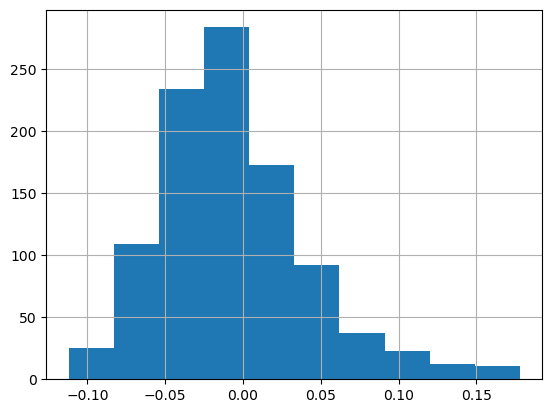

In [3]:
results_df['scale_diff'].hist()

- The mean difference of scale estimates from the two procedures is about -0.005, indicating that the two estimates of scale tend to be very similar, but if anything MLEs tend to be smaller.
- The distribution of the scale estimate differences is skewed slightly to the right

# LogNormal(0, 1) data generating process

In [4]:
lognorm_sim_results = [
    do_one_replicate(
        dgp=d.log_normal.LogNormal(loc=0.0, scale=1.0),
        n_train=20,
        epochs=200, learning_rate=1e-3,
        replicate=i
    ) for i in tqdm(range(1000))
]

lognorm_results_df = pd.DataFrame.from_records(lognorm_sim_results)
lognorm_results_df['scale_diff'] = lognorm_results_df['log_scale'] - lognorm_results_df['quantile_scale']
np.mean(lognorm_results_df['scale_diff'])

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


0.12308097150921822

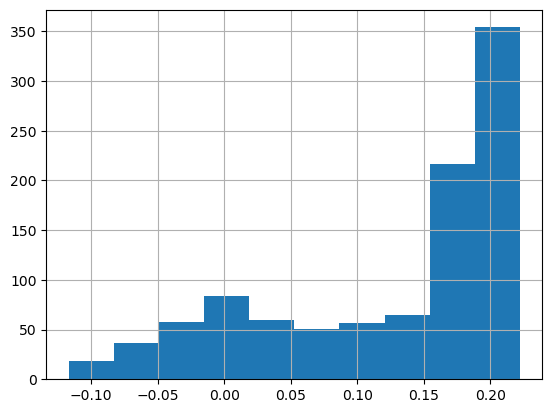

In [5]:
lognorm_results_df['scale_diff'].hist()
plt.show()

- here, the estimates of scale based on maximum likelihood tend to be larger than the estimates of scale from WIS
- the distribution of differences in scale estimates is bimodal and skewed left.  pretty interesting!